# Automatic Malaria Cell Detection Using CNNs in TensorFlow

This notebook demonstrates how to build a Convolutional Neural Network (CNN) model to automatically detect malaria-infected cells from blood smear images. The model aims to improve diagnostic accuracy and reduce the workload of medical professionals by leveraging deep learning techniques with the TensorFlow and Keras libraries.



In [ ]:
from tensorflow.python.keras.layers import AvgPool2D
!pip install tensorflow
!pip install opencv-python

In [1]:
# Importing necessary libs
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import kagglehub
import cv2
import glob
import os

C:\Users\murat\code\ai_model_train\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:55<00:00, 12.9MB/s] 

Extracting files...


Path to dataset files: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1


## Prepare the Data

In [4]:
for root, dirs, files in os.walk(path):
    print(f"\nDirectory: {root}")


Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images\cell_images

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images\cell_images\Parasitized

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images\cell_images\Uninfected

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images\Parasitized

Directory: C:\Users\murat\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1\cell_images\Uninfected


In [5]:
input_shape = (124, 124)

Parasitized = f'{path}/cell_images/Parasitized'
Uninfected = f'{path}/cell_images/Uninfected'

paths = [Parasitized, Uninfected]

In [6]:
allImages = []
allLabels = []

for path in paths:
  path2 = path + '/*.png'
  for file in glob.glob(path2):

    image = cv2.imread(file)

    if image is not None:
      resized = cv2.resize(image, input_shape, interpolation=cv2.INTER_AREA)
      allImages.append(resized)

      if path == Parasitized:
        allLabels.append(1)
      else: # un infect
        allLabels.append(0)

allImagesNP = np.array(allImages)
allLabelsNP = np.array(allLabels)

print(allImagesNP.shape, allLabelsNP.shape)

(27558, 124, 124, 3) (27558,)


In [7]:
print('Save the data')
np.save('resized_malaria/malaria_images_np.npy', allImagesNP)
np.save('resized_malaria/malaria_labels_np.npy', allLabelsNP)

Save the data


## Preprocess

In [9]:
img = allImagesNP[0]
label = allLabelsNP[0]

print(label)

cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1


In [10]:
input_shape = (124, 124, 3)
shape = (124, 124)

In [11]:
# Normalization
allImagesForModel = allImagesNP / 255.0

In [12]:
# Train, Val and Test split
X_train, X_test, y_train, y_test = train_test_split(allImagesForModel, allLabelsNP, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(19290, 124, 124, 3) (19290,)
(4134, 124, 124, 3) (4134,)
(4134, 124, 124, 3) (4134,)


In [13]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [14]:
# Model Defining
model = Sequential()

# Block 1
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(AvgPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

C:\Users\murat\code\ai_final\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 124, 124, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,745,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,894,161 (60.63 MB)

 Trainable params: 15,893,969 (60.63 MB)

 Non-trainable params: 192 (768.00 B)

In [23]:
batch = 32
epochs = 50

steps_per_epochs = int(np.ceil(len(X_train)/ batch))
val_steps = int(np.ceil(len(X_val)/ batch))

In [24]:
best_model_path = 'best_model/best_model_v2.h5'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True)

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    validation_steps=val_steps,
    shuffle=True,
    callbacks=[checkpoint]
)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9519 - loss: 0.1479
Epoch 1: val_accuracy improved from -inf to 0.81834, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 335s 556ms/step - accuracy: 0.9519 - loss: 0.1479 - val_accuracy: 0.8183 - val_loss: 0.3517
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9536 - loss: 0.1455
Epoch 2: val_accuracy improved from 0.81834 to 0.95259, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 328s 544ms/step - accuracy: 0.9536 - loss: 0.1455 - val_accuracy: 0.9526 - val_loss: 0.1558
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9534 - loss: 0.1464
Epoch 3: val_accuracy did not improve from 0.95259
603/603 ━━━━━━━━━━━━━━━━━━━━ 323s 536ms/step - accuracy: 0.9534 - loss: 0.1464 - val_accuracy: 0.9103 - val_loss: 0.2512
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9510 - loss: 0.1467
Epoch 4: val_accuracy did not improve from 0.95259
603/603 ━━━━━━━━━━━━━━━━━━━━ 327s 542ms/step - accuracy: 0.9510 - loss: 0.1467 - val_accuracy: 0.9366 - val_loss: 0.1891
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.9528 - loss: 0.1436
Epoch 5: val_accuracy improved from 0.95259 to 0.95767, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 331s 548ms/step - accuracy: 0.9528 - loss: 0.1436 - val_accuracy: 0.9577 - val_loss: 0.1397
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9551 - loss: 0.1398
Epoch 6: val_accuracy did not improve from 0.95767
603/603 ━━━━━━━━━━━━━━━━━━━━ 324s 536ms/step - accuracy: 0.9551 - loss: 0.1399 - val_accuracy: 0.9543 - val_loss: 0.1432
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9563 - loss: 0.1326
Epoch 7: val_accuracy did not improve from 0.95767
603/603 ━━━━━━━━━━━━━━━━━━━━ 326s 540ms/step - accuracy: 0.9563 - loss: 0.1326 - val_accuracy: 0.9405 - val_loss: 0.2014
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9564 - loss: 0.1414
Epoch 8: val_accuracy improved from 0.95767 to 0.95912, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 327s 542ms/step - accuracy: 0.9564 - loss: 0.1414 - val_accuracy: 0.9591 - val_loss: 0.1317
Epoch 9/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9561 - loss: 0.1267
Epoch 9: val_accuracy did not improve from 0.95912
603/603 ━━━━━━━━━━━━━━━━━━━━ 321s 532ms/step - accuracy: 0.9561 - loss: 0.1267 - val_accuracy: 0.9565 - val_loss: 0.1313
Epoch 10/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9585 - loss: 0.1222
Epoch 10: val_accuracy did not improve from 0.95912
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 531ms/step - accuracy: 0.9585 - loss: 0.1222 - val_accuracy: 0.9533 - val_loss: 0.1324
Epoch 11/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9552 - loss: 0.1312
Epoch 11: val_accuracy did not improve from 0.95912
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 531ms/step - accuracy: 0.9552 - loss: 0.1312 - val_accuracy: 0.9340 - val_loss: 0.2056
Epoch 12/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9571 - loss: 0.1266
Epoch 

603/603 ━━━━━━━━━━━━━━━━━━━━ 324s 538ms/step - accuracy: 0.9555 - loss: 0.1263 - val_accuracy: 0.9606 - val_loss: 0.1374
Epoch 17/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9589 - loss: 0.1223
Epoch 17: val_accuracy did not improve from 0.96057
603/603 ━━━━━━━━━━━━━━━━━━━━ 323s 536ms/step - accuracy: 0.9589 - loss: 0.1223 - val_accuracy: 0.9519 - val_loss: 0.1395
Epoch 18/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9596 - loss: 0.1189
Epoch 18: val_accuracy did not improve from 0.96057
603/603 ━━━━━━━━━━━━━━━━━━━━ 325s 540ms/step - accuracy: 0.9596 - loss: 0.1189 - val_accuracy: 0.9269 - val_loss: 0.2194
Epoch 19/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9605 - loss: 0.1223
Epoch 19: val_accuracy did not improve from 0.96057
603/603 ━━━━━━━━━━━━━━━━━━━━ 328s 543ms/step - accuracy: 0.9605 - loss: 0.1223 - val_accuracy: 0.9594 - val_loss: 0.1220
Epoch 20/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9592 - loss: 0.1261
Epoc

603/603 ━━━━━━━━━━━━━━━━━━━━ 322s 533ms/step - accuracy: 0.9574 - loss: 0.1244 - val_accuracy: 0.9618 - val_loss: 0.1307
Epoch 22/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9582 - loss: 0.1199
Epoch 22: val_accuracy did not improve from 0.96178
603/603 ━━━━━━━━━━━━━━━━━━━━ 319s 528ms/step - accuracy: 0.9582 - loss: 0.1199 - val_accuracy: 0.9615 - val_loss: 0.1359
Epoch 23/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9591 - loss: 0.1183
Epoch 23: val_accuracy improved from 0.96178 to 0.96275, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 319s 529ms/step - accuracy: 0.9592 - loss: 0.1182 - val_accuracy: 0.9627 - val_loss: 0.1253
Epoch 24/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9605 - loss: 0.1153
Epoch 24: val_accuracy did not improve from 0.96275
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 530ms/step - accuracy: 0.9605 - loss: 0.1153 - val_accuracy: 0.9567 - val_loss: 0.1347
Epoch 25/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9627 - loss: 0.1137
Epoch 25: val_accuracy did not improve from 0.96275
603/603 ━━━━━━━━━━━━━━━━━━━━ 318s 528ms/step - accuracy: 0.9627 - loss: 0.1137 - val_accuracy: 0.9611 - val_loss: 0.1161
Epoch 26/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9613 - loss: 0.1169
Epoch 26: val_accuracy did not improve from 0.96275
603/603 ━━━━━━━━━━━━━━━━━━━━ 319s 528ms/step - accuracy: 0.9613 - loss: 0.1169 - val_accuracy: 0.9606 - val_loss: 0.1081
Epoch 27/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9631 - loss: 0.1033
Epoc

603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 531ms/step - accuracy: 0.9642 - loss: 0.1066 - val_accuracy: 0.9630 - val_loss: 0.1309
Epoch 34/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9640 - loss: 0.1107
Epoch 34: val_accuracy did not improve from 0.96299
603/603 ━━━━━━━━━━━━━━━━━━━━ 324s 537ms/step - accuracy: 0.9640 - loss: 0.1107 - val_accuracy: 0.9187 - val_loss: 0.3338
Epoch 35/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9612 - loss: 0.1182
Epoch 35: val_accuracy did not improve from 0.96299
603/603 ━━━━━━━━━━━━━━━━━━━━ 327s 542ms/step - accuracy: 0.9612 - loss: 0.1181 - val_accuracy: 0.9601 - val_loss: 0.1195
Epoch 36/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9644 - loss: 0.1094
Epoch 36: val_accuracy did not improve from 0.96299
603/603 ━━━━━━━━━━━━━━━━━━━━ 330s 546ms/step - accuracy: 0.9644 - loss: 0.1094 - val_accuracy: 0.9565 - val_loss: 0.1234
Epoch 37/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9621 - loss: 0.1126
Epoc

603/603 ━━━━━━━━━━━━━━━━━━━━ 322s 534ms/step - accuracy: 0.9637 - loss: 0.1082 - val_accuracy: 0.9642 - val_loss: 0.1217
Epoch 42/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9650 - loss: 0.1095
Epoch 42: val_accuracy did not improve from 0.96420
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 530ms/step - accuracy: 0.9650 - loss: 0.1095 - val_accuracy: 0.9286 - val_loss: 0.2583
Epoch 43/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9629 - loss: 0.1104
Epoch 43: val_accuracy did not improve from 0.96420
603/603 ━━━━━━━━━━━━━━━━━━━━ 320s 530ms/step - accuracy: 0.9629 - loss: 0.1104 - val_accuracy: 0.9637 - val_loss: 0.1133
Epoch 44/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9623 - loss: 0.1104
Epoch 44: val_accuracy did not improve from 0.96420
603/603 ━━━━━━━━━━━━━━━━━━━━ 321s 532ms/step - accuracy: 0.9623 - loss: 0.1104 - val_accuracy: 0.9603 - val_loss: 0.1405
Epoch 45/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9664 - loss: 0.0981
Epoc

603/603 ━━━━━━━━━━━━━━━━━━━━ 325s 539ms/step - accuracy: 0.9621 - loss: 0.1088 - val_accuracy: 0.9647 - val_loss: 0.1097
Epoch 49/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9631 - loss: 0.1061
Epoch 49: val_accuracy did not improve from 0.96468
603/603 ━━━━━━━━━━━━━━━━━━━━ 325s 539ms/step - accuracy: 0.9631 - loss: 0.1061 - val_accuracy: 0.9596 - val_loss: 0.1199
Epoch 50/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9653 - loss: 0.1000
Epoch 50: val_accuracy improved from 0.96468 to 0.96541, saving model to best_model/best_model_v2.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 326s 541ms/step - accuracy: 0.9653 - loss: 0.1000 - val_accuracy: 0.9654 - val_loss: 0.1086


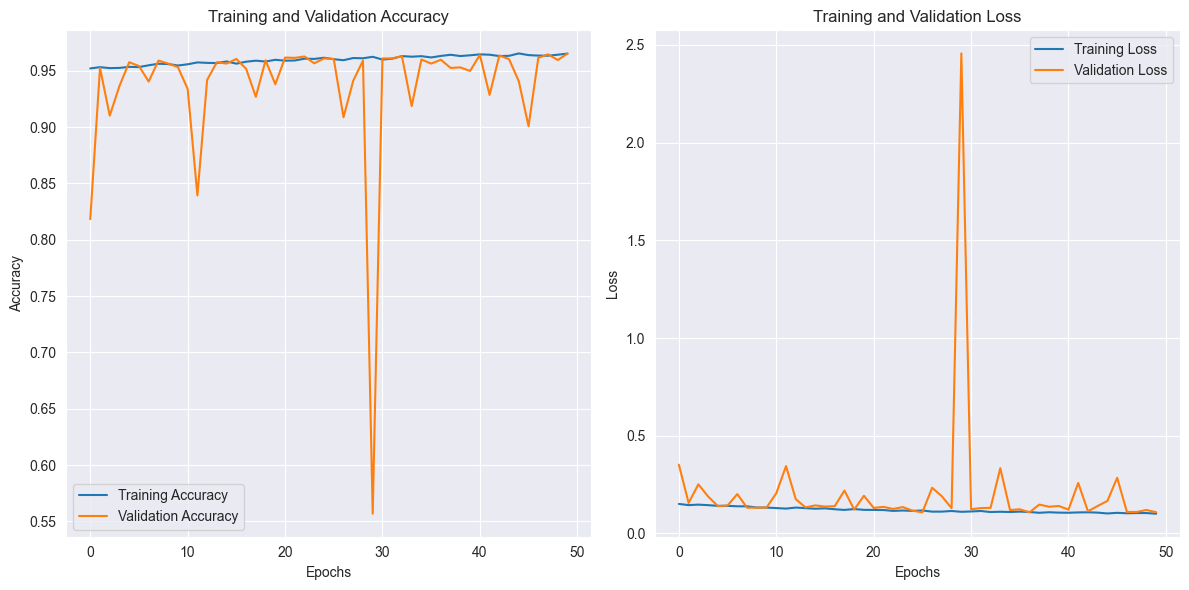

In [29]:
# Plot training  accuracy and loss over epochs
plt.figure(figsize=(12, 6))
os.makedirs("metrics", exist_ok=True)

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Show the plots
plt.tight_layout()
plt.savefig('metrics/training_validation_metrics.png')
plt.show()

In [27]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

130/130 - 10s - 74ms/step - accuracy: 0.9657 - loss: 0.1130

Test accuracy: 0.9656506776809692


In [34]:
# Get predicted probabilities
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step


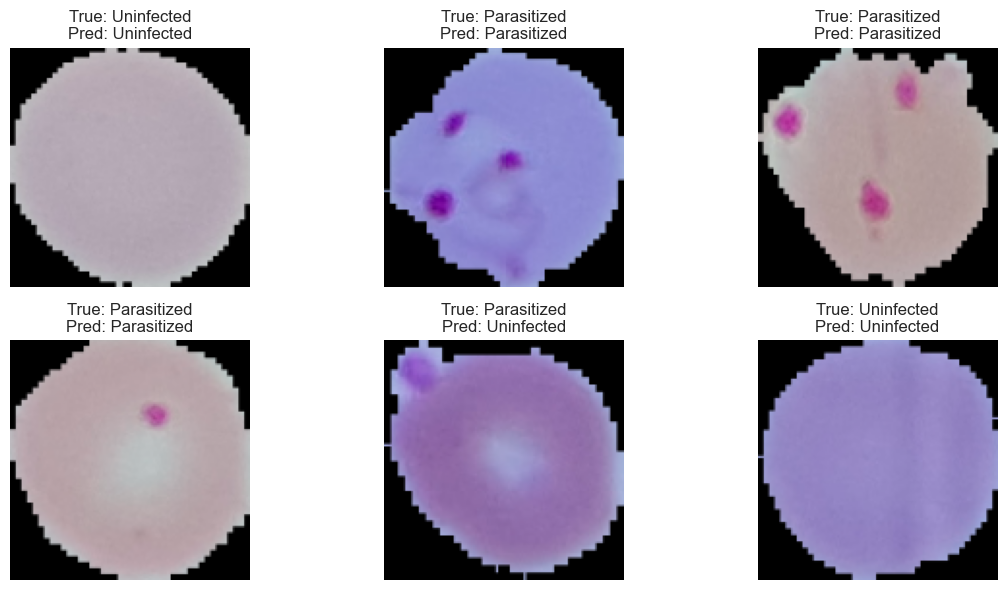

In [39]:
# Show random predictions
plt.figure(figsize=(12, 6))
for i in range(6):
    index = random.randint(0, len(X_test) - 1)
    img = X_test[index]
    true_label = y_test[index]
    predicted_label = y_pred[index]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {'Parasitized' if true_label == 1 else 'Uninfected'}\nPred: {'Parasitized' if predicted_label == 1 else 'Uninfected'}")
plt.tight_layout()
plt.savefig('metrics/random_predictions.png')
plt.show()


In [36]:
class_report = classification_report(y_test, y_pred, target_names=['Uninfected', 'Parasitized'])
print(class_report)

              precision    recall  f1-score   support

  Uninfected       0.96      0.97      0.97      2079
 Parasitized       0.97      0.96      0.97      2055

    accuracy                           0.97      4134
   macro avg       0.97      0.97      0.97      4134
weighted avg       0.97      0.97      0.97      4134



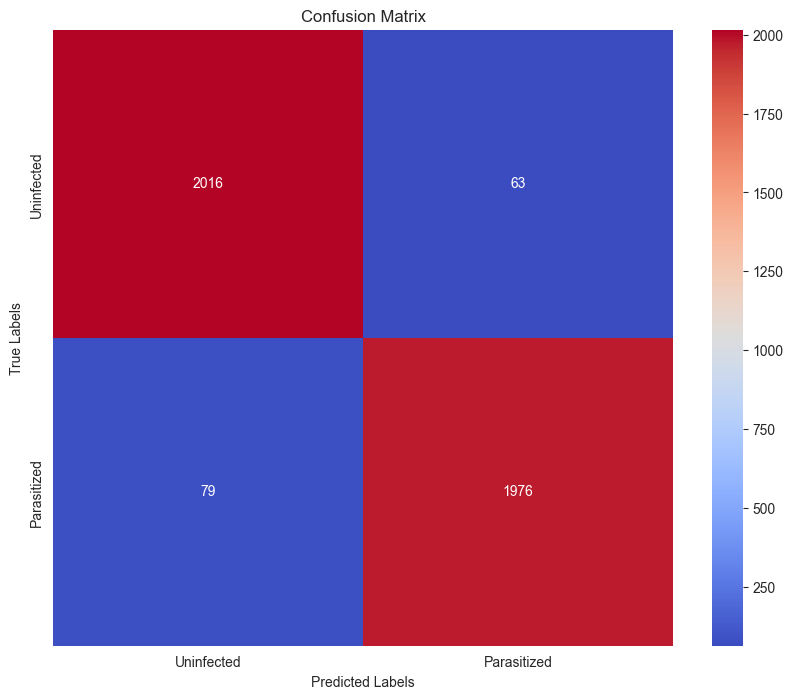

In [40]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('metrics/confusion_matrix.png')
plt.show()